# Memphis Crime Map and Stats

## Environment

In [234]:
import pandas as pd
import pyarrow as pa
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

## Data

In [236]:
# memphis police department: public safety incidents
usecols = ['crime_id', 'crime_date', 'crime_type', 'city', 'latitude', 'longitude'
           , 'block_address', 'crime_category', 'shelby_county_zip_codes'
           , 'city_council_districts', 'memphis_police_department_wards'
           , 'memphis_police_department_districts', 'memphis_police_department_stations', 'count']

crime_df = pd.read_parquet('data/memphis_incidents.parquet', columns=usecols)

In [237]:
crime_df.sample(5).T

,684936,913524,486445,867763,294252
crime_id,1903012359ME [12:447],0704010032ME [14:353],1505013817ME [36:407],2208011755ME [12:550],1103003548ME [33:563]
crime_date,2019-03-26 20:20:00,2007-04-18 21:00:00,2015-05-24 14:45:00,2022-08-23 14:55:00,2011-03-06 14:00:00
crime_type,Vandalism/Misdemeanor,Burglary/Residential,Burglary/Residential,Weapon Law Violations/Misdemeanor,Intimidation/DV
city,Memphis,Memphis,Memphis,Memphis,Memphis
latitude,35.148,35.14,35.074,35.109,35.053
longitude,-89.909,-89.974,-89.873,-89.97,-90.017
block_address,600 N Perkins St,2600 Everett,2700 Sonora,900 Hilton St,3500 Graceland
crime_category,Property Crime,Breaking & Entering,Breaking & Entering,Weapons Offense,Assault
shelby_county_zip_codes,20.0,11.0,14.0,13.0,15.0
city_council_districts,4.0,4.0,3.0,5.0,3.0


In [238]:
# subset to 2018-2022
crime_df['year'] = crime_df.crime_date.dt.year
crime_df = crime_df[crime_df['year'].isin([2018,2019,2020,2021,2022])]

In [239]:
crime_df.value_counts('crime_category')

crime_category
Assault                132758
Theft                  102787
Property Crime          66449
Theft from Vehicle      39811
Breaking & Entering     32383
Theft of Vehicle        30052
Drugs                   23970
Weapons Offense         12462
Robbery                 12235
Disorder                 9348
Traffic                  3107
Vehicle Recovery         3012
Family Offense           1958
Arson                    1687
Homicide                 1403
Kidnapping                803
Liquor                    672
dtype: int64

In [240]:
#crime_focus = ['Assault', 'Theft', 'Property Crime']
#crime_df = crime_df[crime_df['crime_category'].isin(crime_focus)]

In [241]:
# count crimes by year
crime_df.value_counts('year', sort=False)

year
2018     97255
2019     92994
2020     90118
2021     89745
2022    104785
dtype: int64

<AxesSubplot:title={'center':'Memphis Crime Incident Count by Year'}, xlabel='year'>

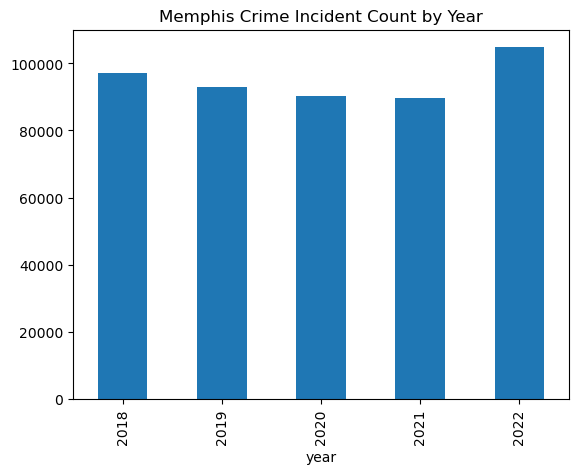

In [242]:
# graph crime count by year
crime_df.value_counts('year', sort=False).plot(kind='bar', title='Memphis Crime Incident Count by Year')

In [243]:
# ward boundaries
ward_df = pd.read_csv('data/mpd_wards.csv')
ward_df.drop(columns=['Ward'], inplace=True)

In [244]:
# rename columns
crime_df.rename(columns={'memphis_police_department_wards':'ward'}, inplace=True)
ward_df.rename(columns={'ORIG_FID':'ward'}, inplace=True)

## Mapping

In [245]:
# fix mapping shape geoms and convert to geodataframe
ward_df['the_geom'] = ward_df['the_geom'].apply(wkt.loads)
ward_gdf = gpd.GeoDataFrame(ward_df, geometry='the_geom')

In [246]:
# percent change over time in crime count by ward
crime_by_ward_year = crime_df.groupby(['ward', 'year'])['crime_id'].count().unstack().fillna(0)
pct_change = (crime_by_ward_year[2022] - crime_by_ward_year[2018]) / crime_by_ward_year[2018] * 100
pct_change.name = 'pct_change'

In [248]:
# top
top = pct_change.sort_values(ascending=False).iloc[0]
# cap
pct_change[pct_change == top] = pct_change.mean()
# review
pct_change.sort_values(ascending=False)

In [250]:
# join percent change and boundaries
crime_pct_gdf = pd.merge(ward_gdf, pct_change, on='ward')

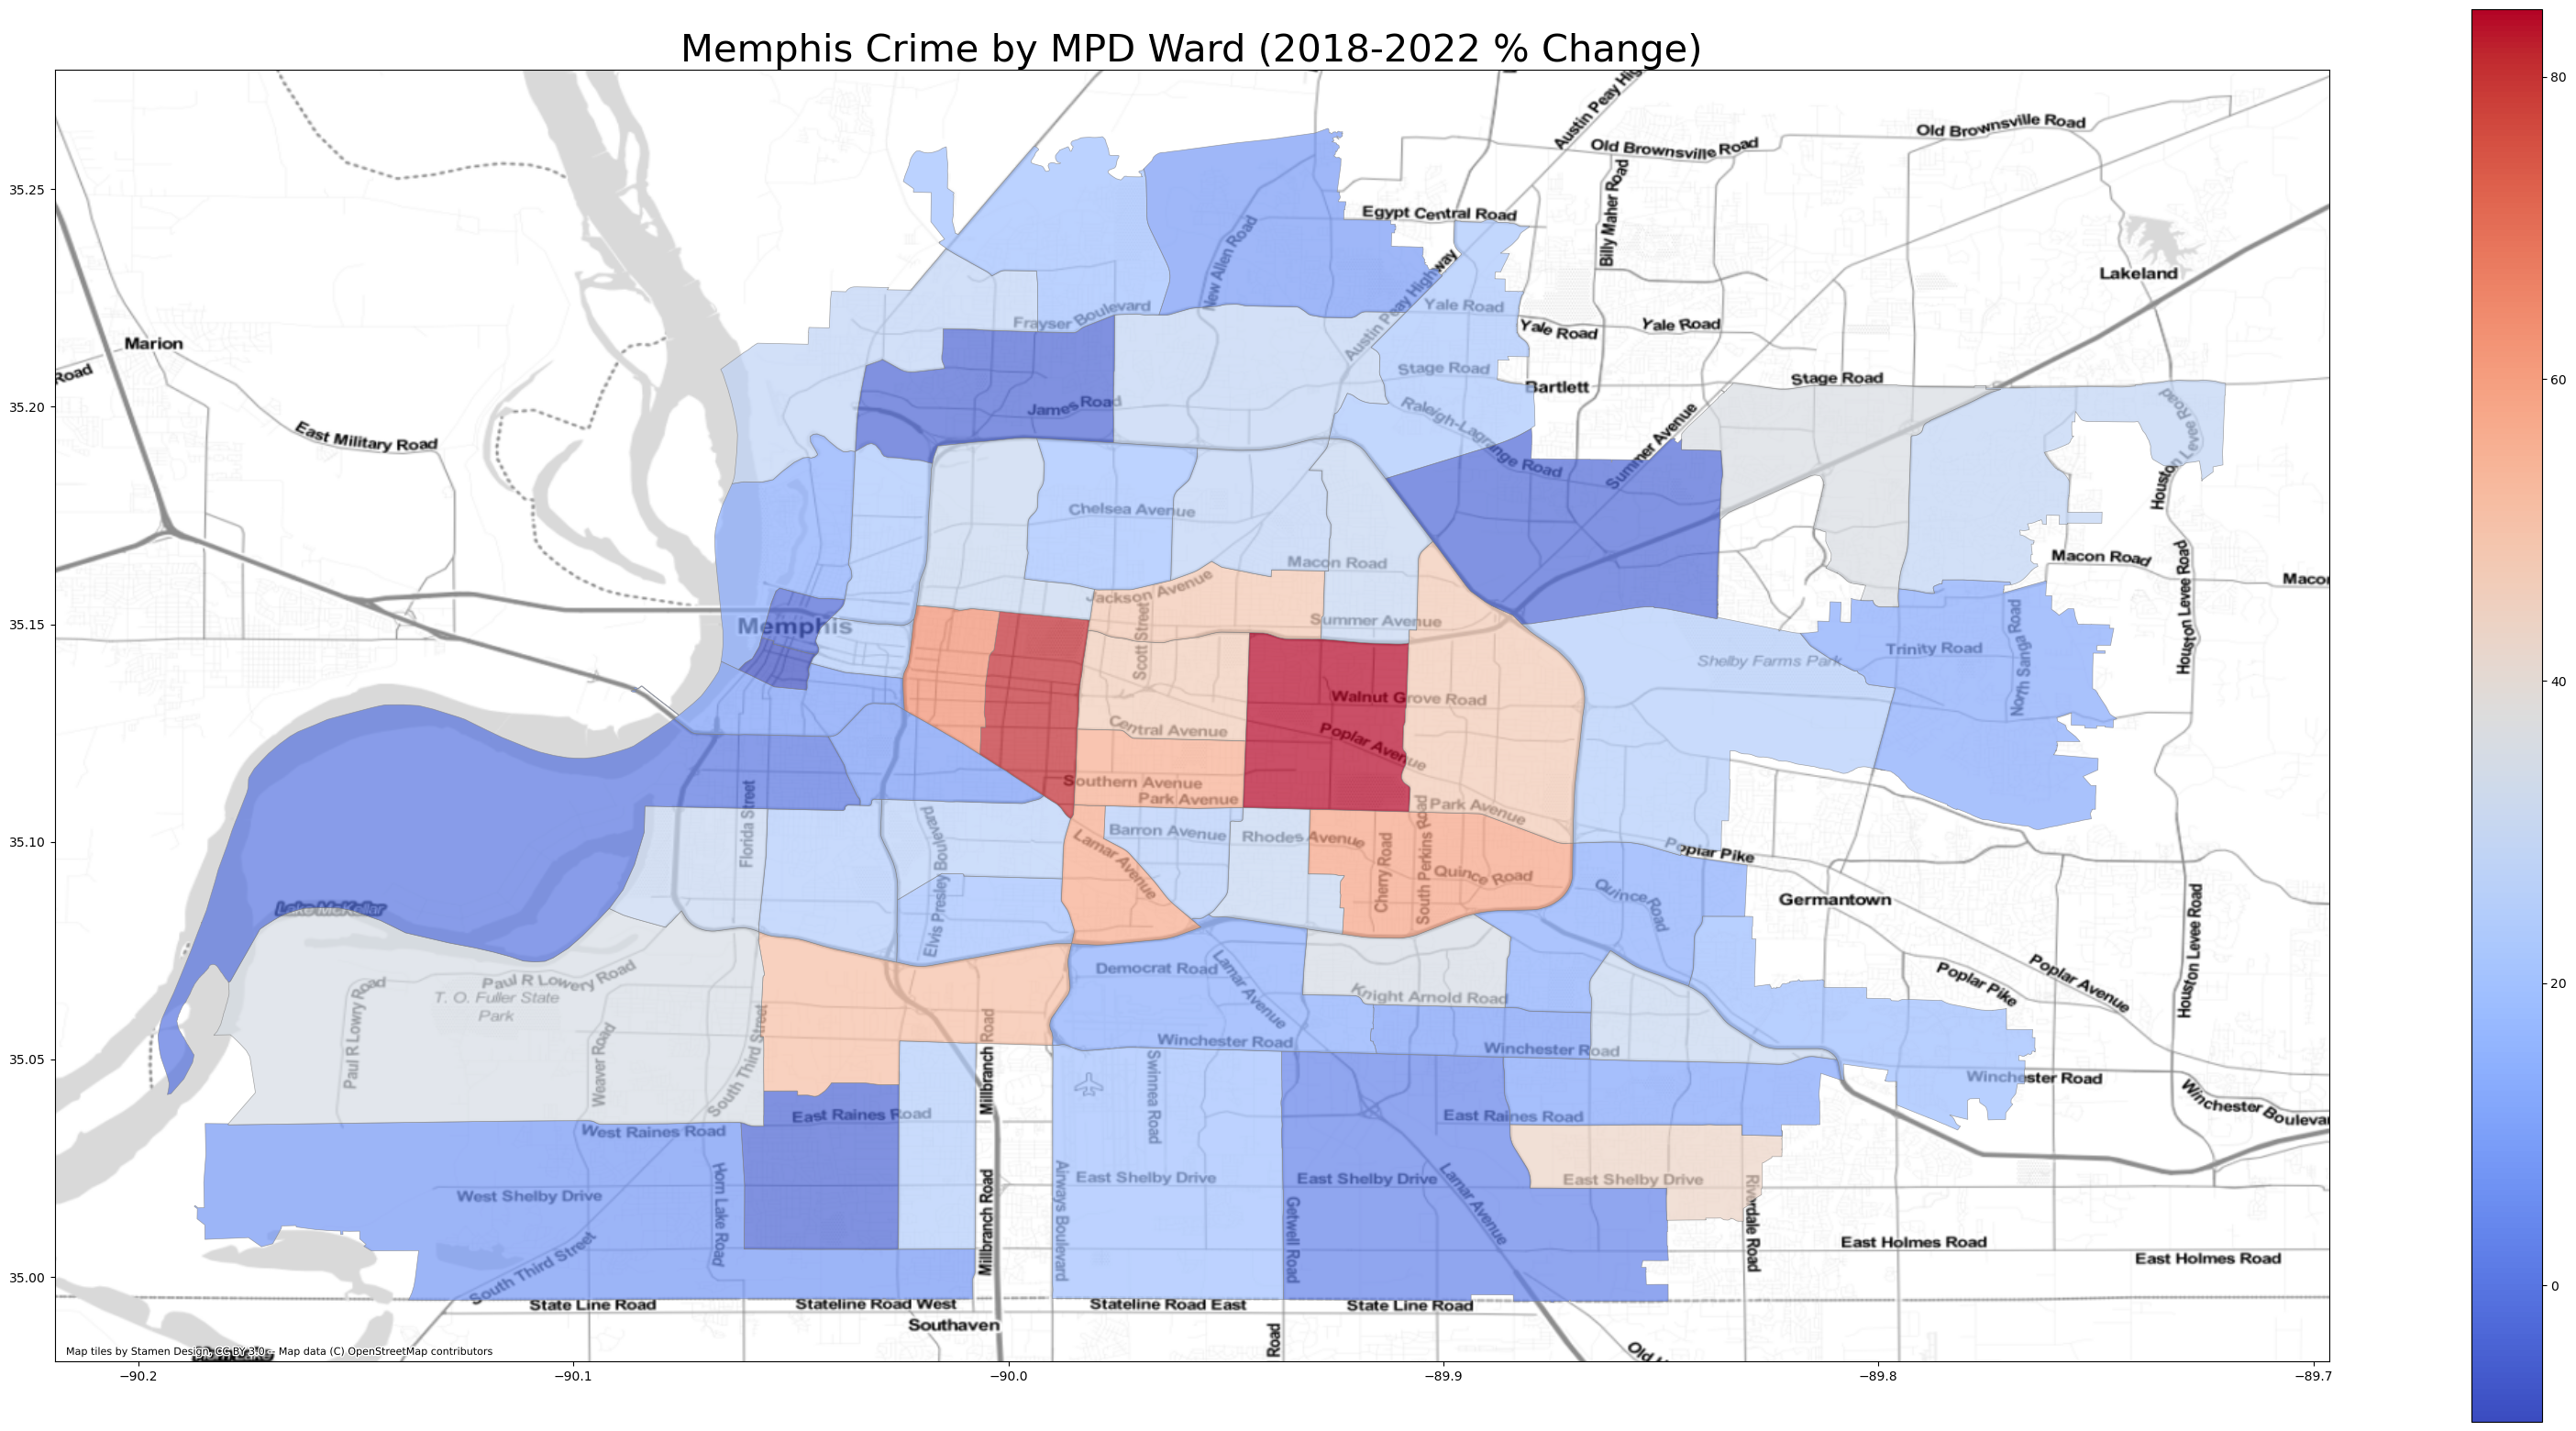

In [253]:
# map
fig, ax = plt.subplots(figsize=(40, 20))
crime_pct_gdf.plot(column='pct_change', cmap='coolwarm', linewidth=0.5, edgecolor='gray', legend=True, ax=ax, alpha=0.7)

ctx.add_basemap(ax=ax, crs=4326, source=ctx.providers.Stamen.TonerLite)

ax.set_title('Memphis Crime by MPD Ward (2018-2022 % Change)', fontsize=30)
plt.show()